# Diseño del controlador STR para el rechazo de perturbaciones

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import scipy as sc
import math

def diophantine_numeric(A, B, Ac):
    """
    Resuelve la ecuación diofantina A*R + B*S = Ac
    para polinomios dados en potencias descendentes (coef[0]*q^0 + ...).

    Devuelve R y S (arrays numpy).
    """
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    Ac = np.array(Ac, dtype=float)

    na = len(A) - 1
    nb = len(B) - 1
    nc = len(Ac) - 1

    # grados de R y S según dimensiones de Åström
    nr = nc - na
    ns = nc - nb
    if nr < 0 or ns < 0:
        raise ValueError("Grados inconsistentes (A_c debe tener mayor grado que A y B).")

    # Matrices que multiplican los coeficientes de R y S
    MA = np.zeros((nc+1, nr+1))
    for i in range(nr+1):
        MA[i:i+na+1, i] = A
    MB = np.zeros((nc+1, ns+1))
    for i in range(ns+1):
        MB[i:i+nb+1, i] = B

    # Sistema lineal
    M = np.hstack((MA, MB))
    rhs = Ac

    x = np.linalg.lstsq(M, rhs, rcond=None)[0]
    R = x[:nr+1]
    S = x[nr+1:]

    # Quiero R_bar monico => obtengo Q para que suceda esto 
    # => tomo la sn. mínima de las infinitas que existen
    Q = (1-R[0])/B[0]

    # Obtengo R_bar y S para el Q dado
    R = np.polyadd(R, np.polymul(Q,B))
    S = np.polyadd(S, -np.polymul(Q,A))
    idx = np.argmax(np.abs(S) > 1e-12)  # primera posición no nula
    S = S[idx:]

    return np.real_if_close(R), np.real_if_close(S)


In [3]:
# Motor. Sistema continuo
s = ctrl.TransferFunction.s
G = 1 / (s * (s + 1))

# Discretización
Ts = 0.5
Gd = ctrl.c2d(G, Ts, method='zoh')
Gd.name = 'Planta'
print(f'Sistema discretizado: {Gd}')

A = Gd.den[0][0]
B = Gd.num[0][0]

# Selección del modelo a seguir: tiene d0=1 (igual a la planta)
Bm = [0.1761, 0]
Am = [1, -1.3205, 0.4966]
Gm = ctrl.TransferFunction(Bm,Am,dt=Ts)
Gm.name='Modelo'
print(f'Ganancia de continua = {np.sum(Bm)/np.sum(Am)}')
print('Modelo a seguir',Gm)

Sistema discretizado: <TransferFunction>: Planta
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

    0.1065 z + 0.0902
  ----------------------
  z^2 - 1.607 z + 0.6065
Ganancia de continua = 1.0000000000000002
Modelo a seguir <TransferFunction>: Modelo
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

         0.1761 z
  ----------------------
  z^2 - 1.321 z + 0.4966


In [4]:
def simular_STR(G,Gm,S,T,R,t,r=None,v=None,sigma_e=0.0,titulo=None):
    # --- Simulación ---    
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    if r is None:
        r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    if v is None:
        v = np.zeros(n_steps)

    e = sigma_e*np.random.randn(n_steps)    
    y = np.zeros(n_steps)
    u = np.zeros(n_steps)

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(len(R), n_steps-1):
        # y[k] = salida actual
        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )

        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Calculo la evolución de y usando el modelo de la planta discretizada
        #y[k+1] = (np.dot(B,u[k:k-len(B):-1]) - np.dot(A[1:], y[k:k+1-len(A):-1]))/A[0]

        # Simular dinámica continua con entrada u[k]            
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1].item() + e[k+1]  # tomar valor al final del período


    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    if not(titulo is None):
        plt.title(titulo)
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()



## Diseñamos el control y evaluamos el efecto de las perturbaciones

R=[1.       0.111095]
S=[ 1.64211563 -0.74700141]
T=[0.89511422 0.        ]


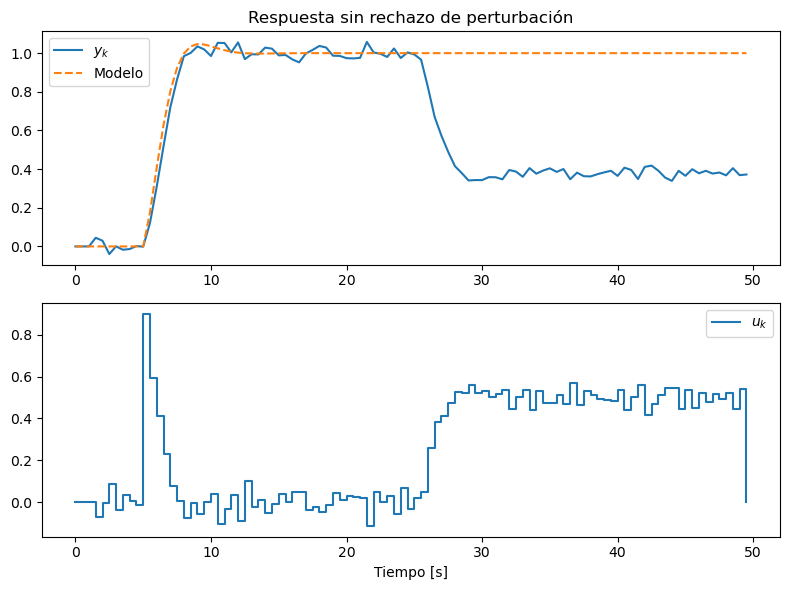

In [5]:
# Factorizamos B
B_mas = [1]
B_menos = B
# Como el cero de la planta no se cancela, entonces debe estar presente en el modelo
# Además la ganancia de continua debe ser unitaria
Bm_bar = np.sum(Am)/np.sum(B_menos)

# Resolvemos la Diofantina
# deg(Ac)=3, deg(A)=2, deg(B-)=1 => deg(Ao)=1 => Ao=[1 a0]
# deg(R)=1, deg(B+)=1 => deg(R_bar)=0 => R_bar=1 (x mónico)
# En este caso la ec. Diofantina resulta muy simple
Ao = [1, 0]

# Resuelvo la diofantina 
R_bar, S = diophantine_numeric(A,B_menos,np.polymul(Ao,Am))

# Paso 3: Construimos R y T
R = np.polymul(R_bar,B_mas)
T = np.polymul(Ao,Bm_bar)
print(f'R={R}')
print(f'S={S}')
print(f'T={T}')

# Simulación
t_final = 50
t = np.arange(0, t_final, Ts)
r = np.zeros_like(t)
r[10:] = 1
v = np.zeros_like(t)
v[50:] = -0.5
simular_STR(G,Gm,S,T,R,t,r=r,v=v,sigma_e=0.02,titulo="Respuesta sin rechazo de perturbación")

## Control con rechazo de perturbación de entrada

R=[ 1.         -0.68973068 -0.31026932]
S=[ 4.46595699 -6.10464695  2.08624707]
T=[ 0.89511422 -0.44755711  0.        ]


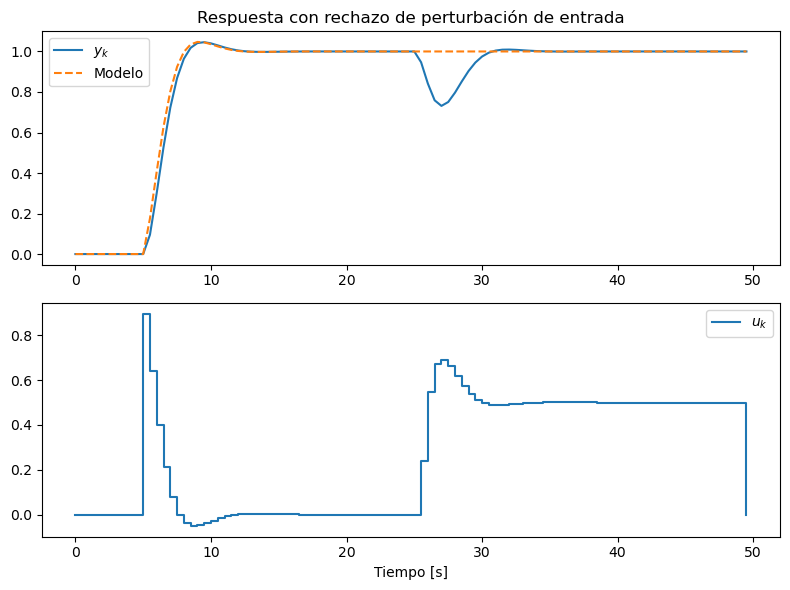

In [5]:
# Factorizamos B
B_mas = [1]
B_menos = B
# Como el cero de la planta no se cancela, entonces debe estar presente en el modelo
# Además la ganancia de continua debe ser unitaria
Bm_bar = np.sum(Am)/np.sum(B_menos)

# Pedimos un polo en 1 (efecto integral)
Rd = [1, -1]

# Resolvemos la Diofantina
ARd = np.polymul(A,Rd)
# Definimos los polos del "observador"
# El segundo polinomio define la velocidad del rechazo de la perturbación 
Ao = np.poly([0,0.5])

# Resuelvo la diofantina 
R_bar, S = diophantine_numeric(ARd,B_menos,np.polymul(Ao,Am))

# Paso 3: Construimos R y T
R = np.polymul(np.polymul(R_bar,B_mas),Rd)
T = np.polymul(Ao,Bm_bar)
print(f'R={R}')
print(f'S={S}')
print(f'T={T}')

# Simulación
t_final = 50
t = np.arange(0, t_final, Ts)
r = np.zeros_like(t)
r[10:] = 1
v = np.zeros_like(t)
v[50:] = -0.5
simular_STR(G,Gm,S,T,R,t,r=r,v=v,sigma_e=0.0,titulo="Respuesta con rechazo de perturbación de entrada")

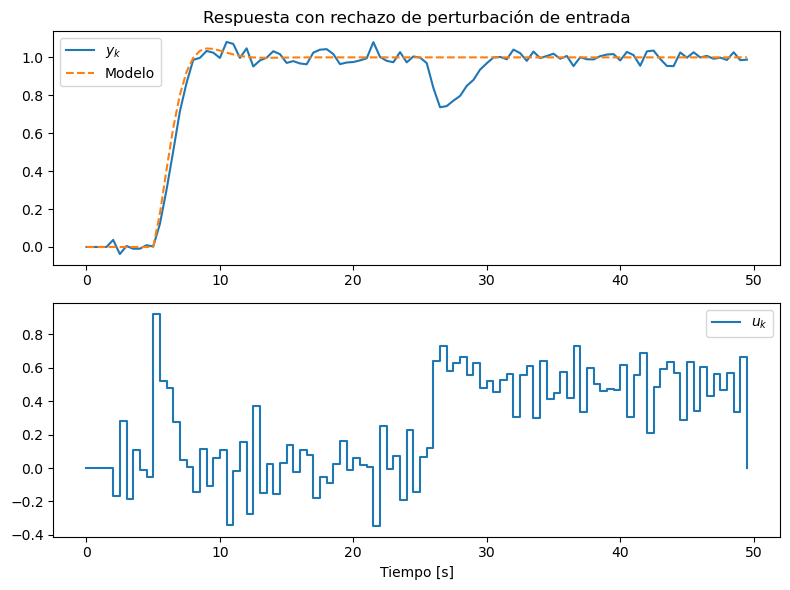

In [6]:
# Repetimos simulación pero con error de medición
# Notar cómo afecta el ruido a la acción de control
simular_STR(G,Gm,S,T,R,t,r=r,v=v,sigma_e=0.02,titulo="Respuesta con rechazo de perturbación de entrada")

## Control con rechazo de perturbación de medición

Observar que la acción de control es menos ruidosa que en el caso anterior donde solo se rechaza perturbaciones de entrada para el mismo nivel de ruido

Verificación Diofantina =[ 0.00000000e+00  0.00000000e+00  1.33226763e-15 -1.22124533e-15
  1.90819582e-16]
R=[ 1.         -0.27008644  0.0450612 ]
S=[ 0.52676948  0.22377855 -0.30299093]
T=[ 0.89511422 -0.44755711  0.        ]
Verificación A*R+B*S - Am*Ao =[ 0.00000000e+00  0.00000000e+00  1.33226763e-15 -1.22124533e-15
  1.90819582e-16]


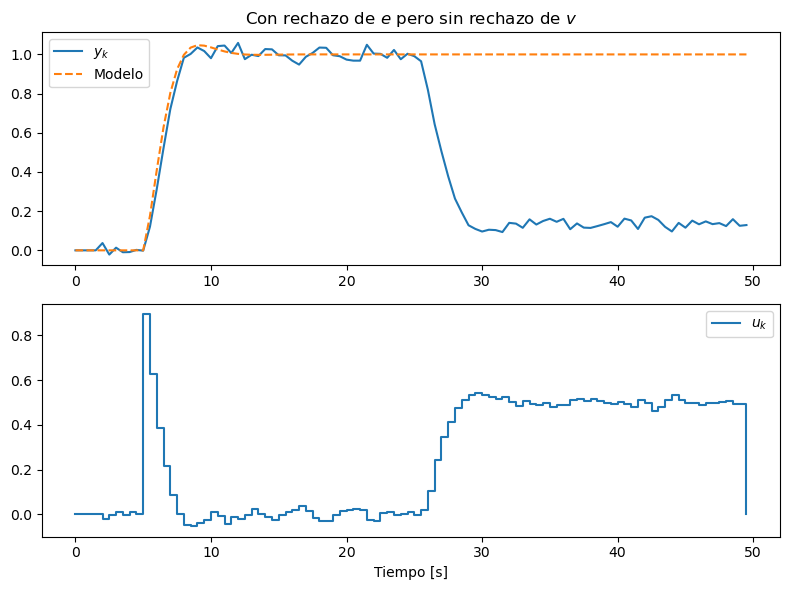

In [7]:
# Factorizamos B
B_mas = [1]
B_menos = B
# Como el cero de la planta no se cancela, entonces debe estar presente en el modelo
# Además la ganancia de continua debe ser unitaria
Bm_bar = np.sum(Am)/np.sum(B_menos)

# No corrijo perturbaciones de entrada
#Rd = [1,-1]
Rd = [1]
# Pido un filtro pasabajos en la señal realimentada, pensado como un promedio móvil de la señal de salida
Sd = [0.5,0.5]

# Resolvemos la Diofantina
ARd = np.polymul(A,Rd)
B_menosSd = np.polymul(B_menos,Sd)

# Definimos los polos del "observador"
Ao = np.poly([0,.5])
Acl_bar = np.polymul(Ao,Am)

# Resuelvo la diofantina 
R_bar, S_bar = diophantine_numeric(ARd,B_menosSd,Acl_bar)
print(f'Verificación Diofantina ={np.polyadd(np.polymul(ARd,R_bar),np.polymul(B_menosSd,S_bar))-np.polymul(Am,Ao)}')

# Paso 3: Construimos R y T
S = np.polymul(Sd,S_bar)
R = np.polymul(np.polymul(R_bar,B_mas),Rd)
T = np.polymul(Ao,Bm_bar)
print(f'R={R}')
print(f'S={S}')
print(f'T={T}')
print(f'Verificación A*R+B*S - Am*Ao ={np.polyadd(np.polymul(A,R),np.polymul(B,S))-Acl_bar}')

# Simulación
t_final = 50
t = np.arange(0, t_final, Ts)
r = np.zeros_like(t)
r[10:] = 1
v = np.zeros_like(t)
v[50:] = -0.5
simular_STR(G,Gm,S,T,R,t,r=r,v=v,sigma_e=0.02,titulo="Con rechazo de $e$ pero sin rechazo de $v$")

## Adaptativo indirecto con rechazo de perturbación de entrada

Observar:
- El integrador corrige la perturbación escalón en $v$, pero como le lleva un tiempo conseguir el rechazo se produce un error de estimación
- El error de estimación lleva a cambiar la identificación de los parámetros de la planta => produce un sesgo  
- El controlador se reajusta en base a este sesgo y le recorta acción de control al integrador
- El escalón se rechaza en parte por el integrador (respuesta rápida) y en parte por el identificador (sesgo en parámetros)
- Luego de un tiempo el factor de olvido lleva la estimación de los parámetros hacia los valores "reales"
- Y el integrador termina por rechazar por completo la perturbación 

-136


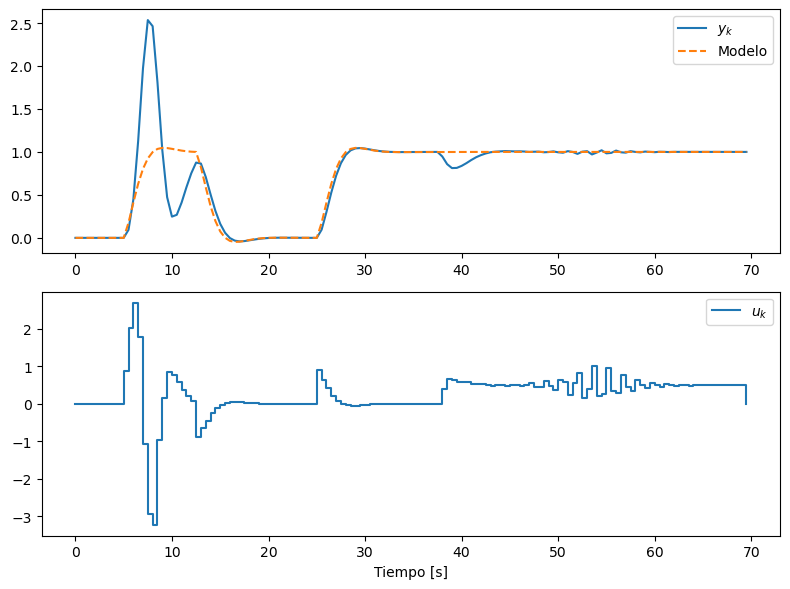

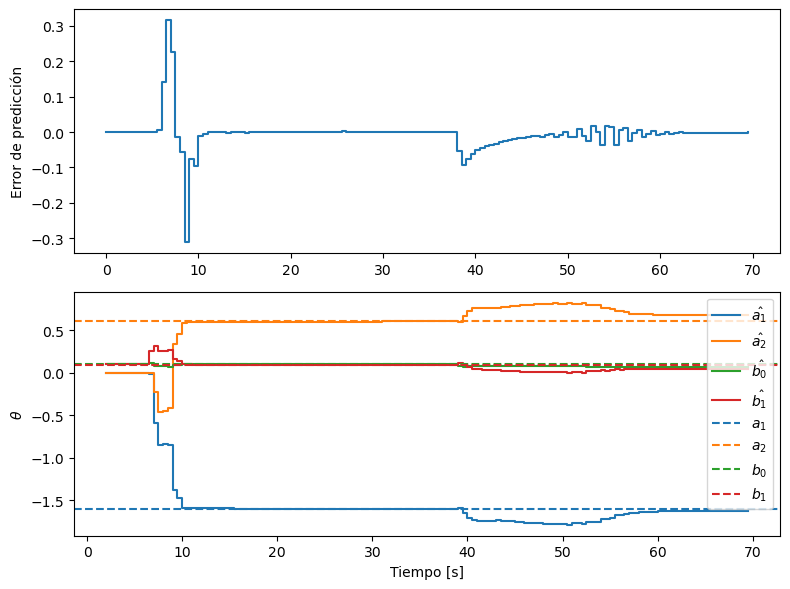

In [8]:
def simular_STR_indirecto(G,Gm,t,r=None,v=None,sigma_e=0.0):
    # --- Simulación ---    
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    if r is None:
        r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    if v is None:
        v = np.zeros(n_steps)

    e = sigma_e*np.random.randn(n_steps)    
    y = np.zeros(n_steps)
    u = np.zeros(n_steps)

    y = np.zeros(n_steps)
    y_hat = np.zeros_like(y)
    err = np.zeros_like(y)
    u = np.zeros(n_steps)

    lambda_ = 0.95
    na = 2
    nb = 2

    theta_hat = np.zeros(na+nb)
    theta_hat[-1] = 0.1
    theta_hat[-2] = 0.1
    P = 100 * np.eye(na+nb)          # matriz de incertidumbre grande
    theta_hist = []    
    theta_real = [-1.6065, 0.6065, 0.1065, 0.0902]

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(3, n_steps-1):
        # **********  Identificación
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1]))   # vector de regresores
        y_hat[k] = phi @ theta_hat
        err[k] = y[k] - y_hat[k]

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        # Armo los polinomios de la planta según la identificación
        A = [1 , theta_hat[0], theta_hat[1]]
        B = [theta_hat[2], theta_hat[3]]
        

        # **********  Cálculo del controlador
        # Parámetros de diseño del control
        Bm_bar = np.sum(Gm.den[0][0])/np.sum(B)

        # Pedimos un polo en 1 (efecto integral)
        Rd = [1, -1]
        ARd = np.polymul(A,Rd)

        # Definimos los polos del "observador"
        Ao = np.poly([0,0])

        # Resuelvo la diofantina 
        R_bar, S = diophantine_numeric(ARd,B,np.polymul(Ao,Gm.den[0][0]))

        # Construimos R y T
        R = np.polymul(R_bar,Rd)
        T = np.polymul(Ao,Bm_bar)

        # **********  Cálculo de la acción de control
        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )
        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Calculo la evolución de y usando el modelo de la planta discretizada
        #y[k+1] = (np.dot(B,u[k:k-len(B):-1]) - np.dot(A[1:], y[k:k+1-len(A):-1]))/A[0]

        # Simular dinámica continua con entrada u[k]
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1].item() + e[k+1]

        theta_hist.append(theta_hat.copy())


    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()


    theta_hist = np.array(theta_hist)
    plt.figure(figsize=(8,6))
    plt.subplot(211)        
    plt.step(t,err,where='post')
    #plt.xlabel('Tiempo [s]')
    plt.ylabel('Error de predicción')
    plt.subplot(212)
    print(-len(theta_hist))
    for idx_na in range(0,na):        
        plt.step(t[-len(theta_hist):],theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
    for idx_nb in range(0,nb):
        plt.step(t[-len(theta_hist):],theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb}}}$",where='post')

    if theta_real!=None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for idx_na in range(na):
            color = colors[idx_na % len(colors)]
            plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na+1}$")
        for idx_nb in range(nb):
            color = colors[(idx_nb+na) % len(colors)]
            plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            

    plt.legend()
    plt.xlabel('Tiempo [s]')
    plt.ylabel('$\\theta$')
    plt.tight_layout()    
    plt.show()


# Simulación
t_final = 70
t = np.arange(0, t_final, Ts)
r = np.zeros_like(t)
r[10:25] = 1
r[50:] = 1
v = np.zeros_like(t)
v[75:] = -0.5
simular_STR_indirecto(G,Gm,t,r=r,v=v,sigma_e=0.0)

## Adaptativo indirecto con rechazo de perturbación de entrada y error de medición

Observar:
- Al igual que el caso anterior, los parámetros quedan sesgados por la aparición de $v$
- Pero rápidamente vuelven a los valores "reales" gracias a que el ruido de medición produce una actualización más ágil de los parámetros identificados
- Pero como el modelo de la planta no es ARX, al final se tiene un sesgo
- Y la acción de control se torna inviable

-136


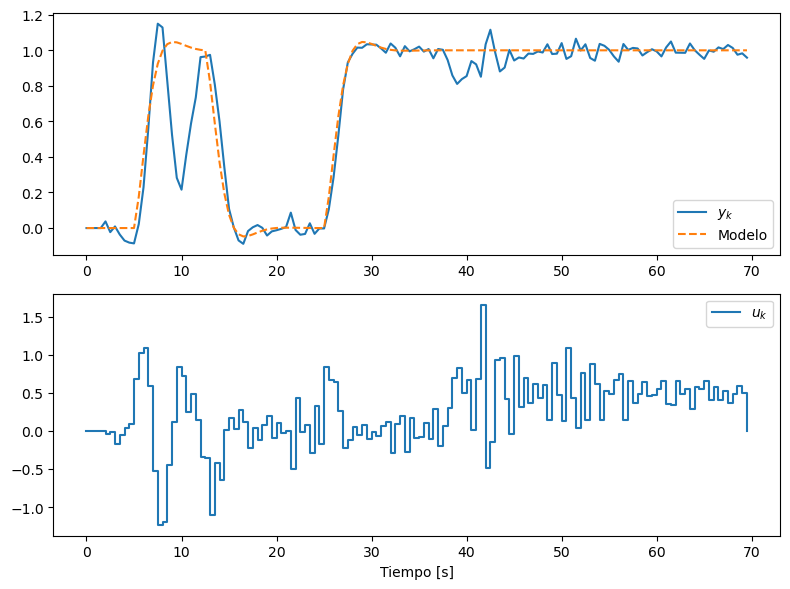

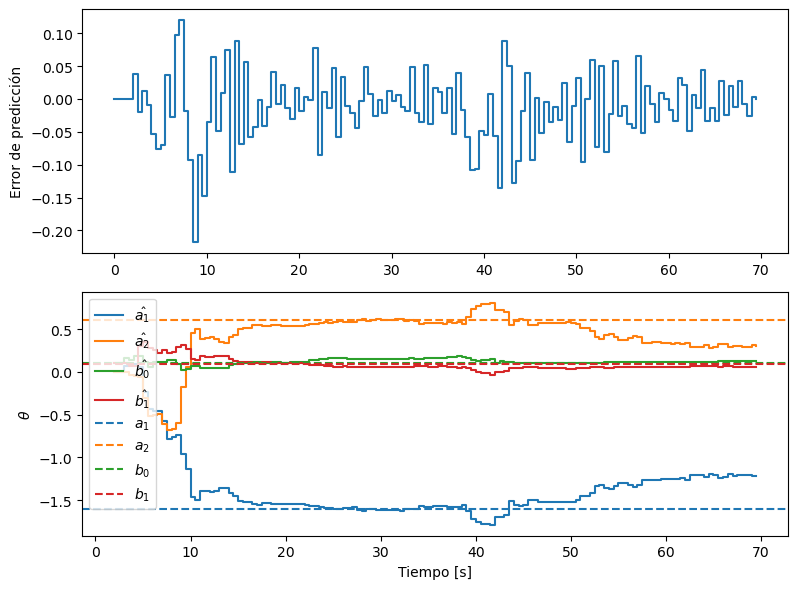

In [95]:
simular_STR_indirecto(G,Gm,t,r=r,v=v,sigma_e=0.02)

## Adaptativo indirecto con rechazo de perturbación de entrada

Se implementa un método de identificación modificado, donde el regresor se arma con variables $u_f$, $y_f$

Estas variables filtradas vienen de aplicarles el modelo de la perturbación, de esta forma el identificador es inmune a estas perturbaciones y no las interpreta como un cambio de la planta.

El integrador es quien produce el rechazo



-136


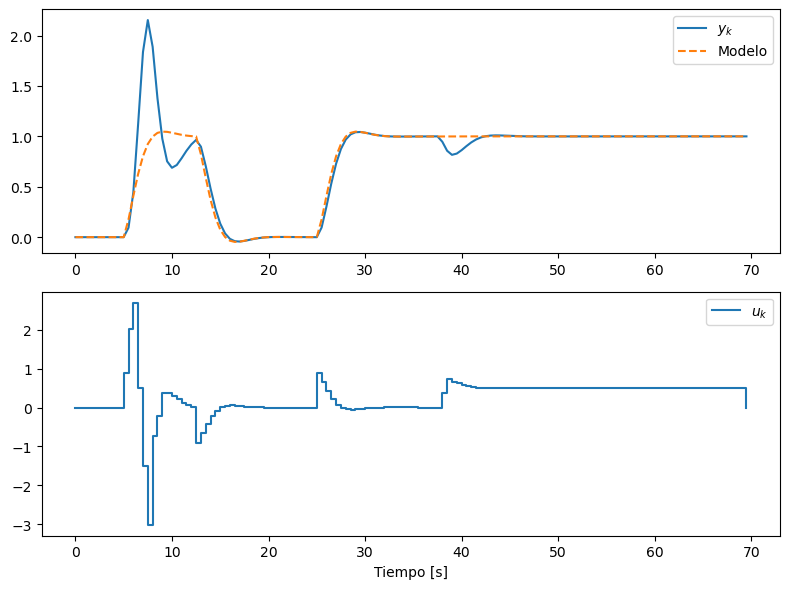

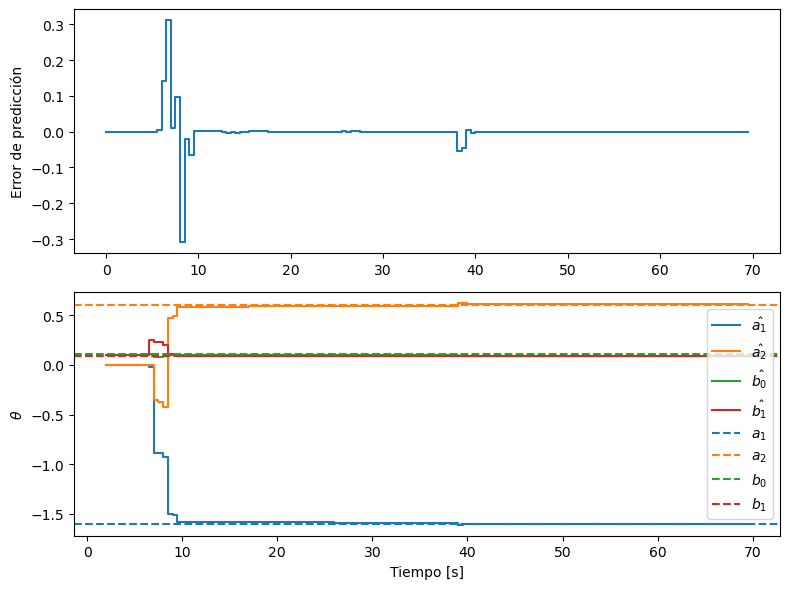

In [107]:
def simular_STR_indirecto(G,Gm,t,r=None,v=None,sigma_e=0.0):
    # --- Simulación ---    
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    if r is None:
        r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    if v is None:
        v = np.zeros(n_steps)

    e = sigma_e*np.random.randn(n_steps)    
    y = np.zeros(n_steps)
    u = np.zeros(n_steps)

    y = np.zeros(n_steps)
    y_hat = np.zeros_like(y)
    err = np.zeros_like(y)
    u = np.zeros(n_steps)

    yf = np.zeros(n_steps)
    uf = np.zeros(n_steps)

    lambda_ = 0.95
    na = 2
    nb = 2

    theta_hat = np.zeros(na+nb)
    theta_hat[-1] = 0.1
    theta_hat[-2] = 0.1
    P = 100 * np.eye(na+nb)          # matriz de incertidumbre grande
    theta_hist = []    
    theta_real = [-1.6065, 0.6065, 0.1065, 0.0902]

    # Modelo de la perturbación
    Ad = [1, -1]

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(3, n_steps-1):
        # **********  Filtrado de las señales del identificador
        yf[k] = Ad @ y[k:k-len(Ad):-1]
        uf[k-1] = Ad @ u[k-1:k-1-len(Ad):-1]

        # **********  Identificación
        phi = np.concatenate((-yf[k-1:k-na-1:-1], uf[k-1:k-nb-1:-1]))   # vector de regresores
        y_hat[k] = phi @ theta_hat
        err[k] = yf[k] - y_hat[k]

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        # Armo los polinomios de la planta según la identificación
        A = [1 , theta_hat[0], theta_hat[1]]
        B = [theta_hat[2], theta_hat[3]]
        

        # **********  Cálculo del controlador
        # Parámetros de diseño del control
        Bm_bar = np.sum(Gm.den[0][0])/np.sum(B)

        # Pedimos un polo en 1 (efecto integral)
        Rd = Ad
        ARd = np.polymul(A,Rd)

        # Definimos los polos del "observador"
        Ao = np.poly([0,0])

        # Resuelvo la diofantina 
        R_bar, S = diophantine_numeric(ARd,B,np.polymul(Ao,Gm.den[0][0]))

        # Construimos R y T
        R = np.polymul(R_bar,Rd)
        T = np.polymul(Ao,Bm_bar)

        # **********  Cálculo de la acción de control
        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )
        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Calculo la evolución de y usando el modelo de la planta discretizada
        #y[k+1] = (np.dot(B,u[k:k-len(B):-1]) - np.dot(A[1:], y[k:k+1-len(A):-1]))/A[0]

        # Simular dinámica continua con entrada u[k]
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1].item() + e[k+1]

        theta_hist.append(theta_hat.copy())


    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()


    theta_hist = np.array(theta_hist)
    plt.figure(figsize=(8,6))
    plt.subplot(211)        
    plt.step(t,err,where='post')
    #plt.xlabel('Tiempo [s]')
    plt.ylabel('Error de predicción')
    plt.subplot(212)
    print(-len(theta_hist))
    for idx_na in range(0,na):        
        plt.step(t[-len(theta_hist):],theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
    for idx_nb in range(0,nb):
        plt.step(t[-len(theta_hist):],theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb}}}$",where='post')

    if theta_real!=None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for idx_na in range(na):
            color = colors[idx_na % len(colors)]
            plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na+1}$")
        for idx_nb in range(nb):
            color = colors[(idx_nb+na) % len(colors)]
            plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            

    plt.legend()
    plt.xlabel('Tiempo [s]')
    plt.ylabel('$\\theta$')
    plt.tight_layout()    
    plt.show()


# Simulación
t_final = 70
t = np.arange(0, t_final, Ts)
r = np.zeros_like(t)
r[10:25] = 1
r[50:] = 1
v = np.zeros_like(t)
v[75:] = -0.5
simular_STR_indirecto(G,Gm,t,r=r,v=v,sigma_e=0.0)

-136


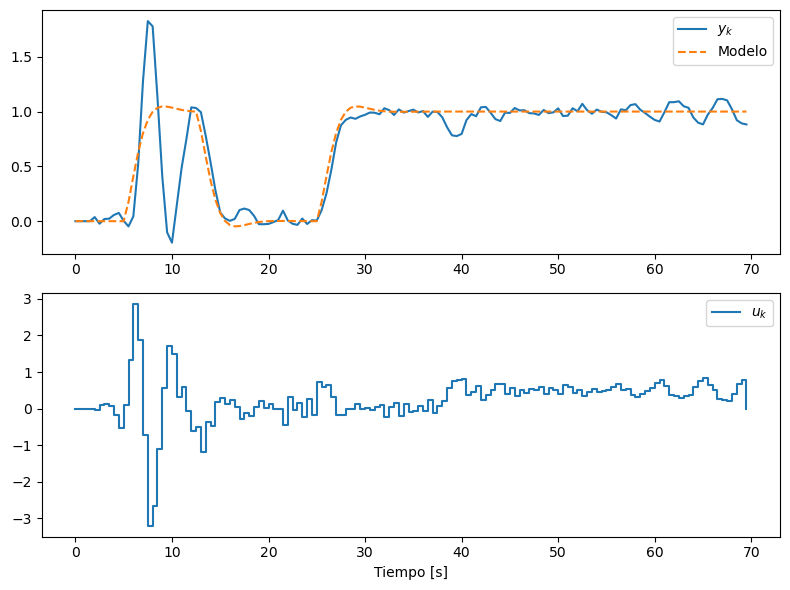

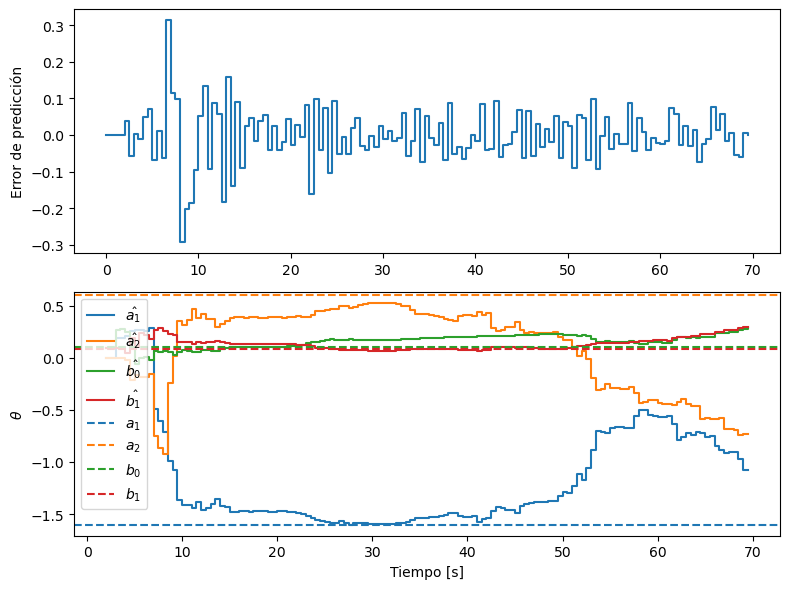

In [108]:
simular_STR_indirecto(G,Gm,t,r=r,v=v,sigma_e=0.02)

## Actualización del identificador para que no afecte el ruido de medición en la estimación

Como el modelo OE es no lineal, PEM recursivo no se comporta nada bien para este sistema: no logra convergencia!

Utilizo en su lugar un optimizador por Levenberg–Marquard, considerando como objetivo disminuir el error de simulación

Se toma una ventana de muestras.

/tmp/ipykernel_6760/3196237416.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  Bm_bar = np.sum(Gm.den[0][0])/np.sum(B)
/tmp/ipykernel_6760/2311923892.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  Q = (1-R[0])/B[0]


-134


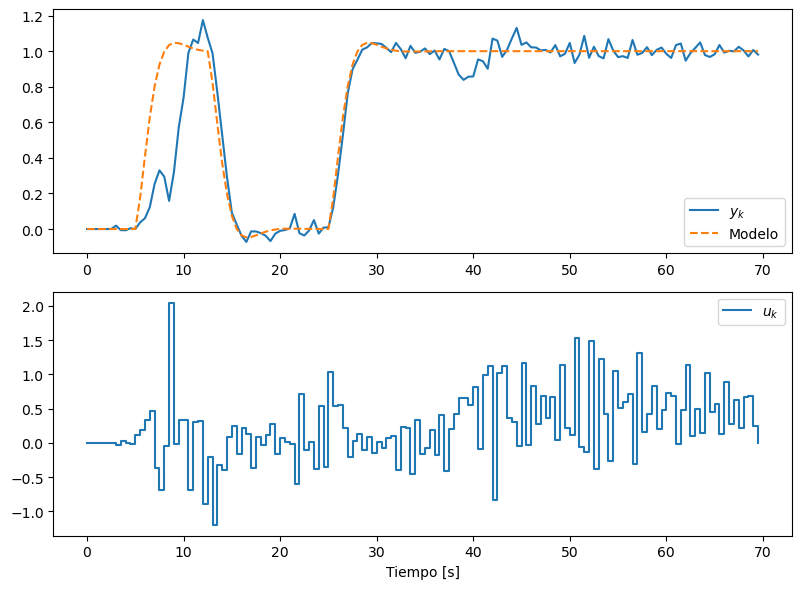

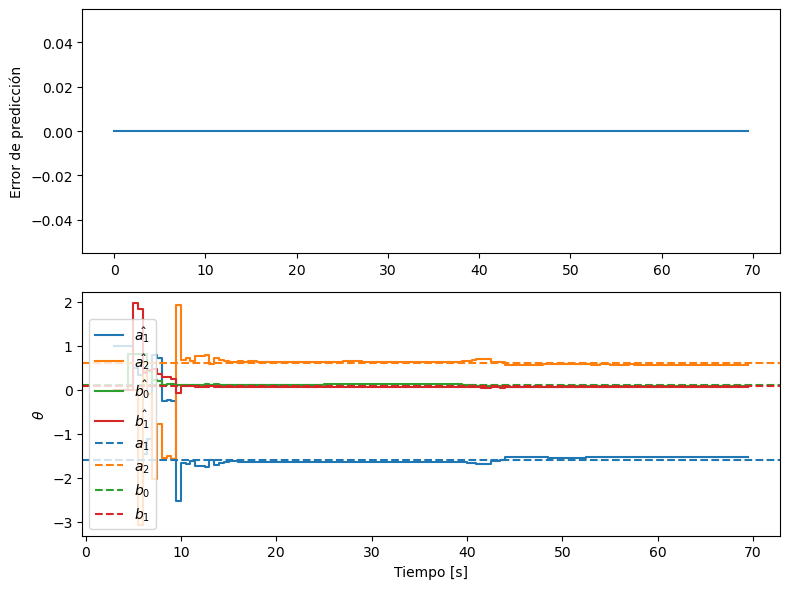

In [ ]:
from scipy.optimize import least_squares
from scipy.signal import lfilter

def simular_STR_indirecto(G,Gm,t,r=None,v=None,sigma_e=0.0):
    # --- Simulación ---    
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    if r is None:
        r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    if v is None:
        v = np.zeros(n_steps)

    e = sigma_e*np.random.randn(n_steps)    
    y = np.zeros(n_steps)
    u = np.zeros(n_steps)

    y = np.zeros(n_steps)
    y_hat = np.zeros_like(y)
    err = np.zeros_like(y)
    u = np.zeros(n_steps)

    yf = np.zeros(n_steps)
    uf = np.zeros(n_steps)

    na = 2
    nb = 2

    theta_hat = np.r_[1,0,0,0]
    theta_hist = []    
    theta_real = [-1.6065, 0.6065, 0.1065, 0.0902]

    # Modelo de la perturbación
    Ad = [1, -1]

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    
    def residuals(theta, u, y_meas, na, nb):
        # Extraer parámetros
        a = np.r_[1, theta[:na]]        # [1, a1, ..., a_na]
        b = np.r_[0, theta[na:na+nb]]   # [0, b1, ..., b_nb]
        # Simulación con lfilter
        y_sim = lfilter(b, a, u)
        return y_sim - y_meas


    for k in range(na+nb+1, n_steps-1):
        # **********  Filtrado de las señales del identificador
        yf[k] = Ad @ y[k:k-len(Ad):-1]
        uf[k-1] = Ad @ u[k-1:k-1-len(Ad):-1]

        # **********  Identificación
        window = min(k, 300)
        res = least_squares(residuals, 
                            theta_hat, 
                            args=(uf[k-window:k], yf[k-window:k],na,nb),
                            method='lm',
                            max_nfev=100)
        theta_hat = res.x
        
        # Armo los polinomios de la planta según la identificación
        A = np.r_[1, theta_hat[:na]]
        B = np.r_[theta_hat[na:na+nb]]        

        # **********  Cálculo del controlador
        # Parámetros de diseño del control
        Bm_bar = np.sum(Gm.den[0][0])/np.sum(B)

        # Pedimos un polo en 1 (efecto integral)
        Rd = Ad
        ARd = np.polymul(A,Rd)

        # Definimos los polos del "observador"
        Ao = np.poly([0,0])

        # Resuelvo la diofantina 
        R_bar, S = diophantine_numeric(ARd,B,np.polymul(Ao,Gm.den[0][0]))

        # Construimos R y T
        R = np.polymul(R_bar,Rd)
        T = np.polymul(Ao,Bm_bar)

        # Si arranco con adaptativo de una, se va a los caños
        if k<10:
            R=[1,       0.111095]
            S=[ 1.64211563, -0.74700141]
            T=[0.89511422, 0        ]

        # **********  Cálculo de la acción de control
        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )
        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Simular dinámica continua con entrada u[k]
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1].item() + e[k+1]

        theta_hist.append(theta_hat.copy())


    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()


    theta_hist = np.array(theta_hist)
    plt.figure(figsize=(8,6))
    plt.subplot(211)        
    plt.step(t,err,where='post')
    #plt.xlabel('Tiempo [s]')
    plt.ylabel('Error de predicción')
    plt.subplot(212)
    print(-len(theta_hist))
    for idx_na in range(0,na):        
        plt.step(t[-len(theta_hist):],theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
    for idx_nb in range(0,nb):
        plt.step(t[-len(theta_hist):],theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb}}}$",where='post')

    if theta_real!=None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for idx_na in range(na):
            color = colors[idx_na % len(colors)]
            plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na+1}$")
        for idx_nb in range(nb):
            color = colors[(idx_nb+na) % len(colors)]
            plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            

    plt.legend()
    plt.xlabel('Tiempo [s]')
    plt.ylabel('$\\theta$')
    plt.tight_layout()    
    plt.show()


# Simulación
t_final = 70
t = np.arange(0, t_final, Ts)
r = np.zeros_like(t)
r[10:25] = 1
r[50:] = 1
v = np.zeros_like(t)
v[75:] = -0.5
simular_STR_indirecto(G,Gm,t,r=r,v=v,sigma_e=0.02)